In [25]:
from tensorflow.keras.callbacks import LearningRateScheduler, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings
import glob 
import os 

# Make NumPy printouts easier to read.
np.set_printoptions(precision=5, suppress=True)
warnings.filterwarnings("ignore")

print(tf.__version__)

2.10.0


In [26]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [27]:
def custom_scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


def build_and_compile_model_input(k):
      model = tf.keras.models.Sequential([
          tf.keras.layers.Dense(512, activation='relu', input_shape=(k,)),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(32, activation='relu'),
          tf.keras.layers.Dense(1,activation='linear') 
    ])

      model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    loss="mse",
                    metrics=['mae'])
      return model

scheduler = LearningRateScheduler(custom_scheduler)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)
callbacks = [scheduler, tensorboard]

EPOCHS = 50
BATCH_SIZE=64

DATASET_CALOSC=pd.read_csv('../Dane/data_nowe/dane_przetworzone/12_wybranych_nowy_parametr/calosc/calosc.csv')
DATASET_CALOSC_MAX=DATASET_CALOSC['Tyg_zuzycie'].max()
DATASET_CALOSC['Tyg_zuzycie'] = (DATASET_CALOSC['Tyg_zuzycie']) / (DATASET_CALOSC['Tyg_zuzycie'].max())


In [28]:
input_3_plot=np.arange(0,1,1/1440) 
input_3=np.vstack((2*np.ones_like(input_3_plot, dtype=int),2*np.ones_like(input_3_plot, dtype=int),input_3_plot)).T

In [29]:
DATASET_CALOSC

,Pora_roku,Dzien_tygodnia,Czas_dnia,Przeplyw,Tyg_zuzycie
0,2.0,1.0,0.000000,0.0,0.132987
1,2.0,1.0,0.000694,0.0,0.132987
2,2.0,1.0,0.001389,0.0,0.132987
3,2.0,1.0,0.002083,0.0,0.132987
4,2.0,1.0,0.002778,0.0,0.132987
...,...,...,...,...,...
2096635,1.0,7.0,0.996528,0.0,0.251192
2096636,1.0,7.0,0.997222,0.0,0.251192
2096637,1.0,7.0,0.997917,0.0,0.251192
2096638,1.0,7.0,0.998611,0.0,0.251192


# model 3 input

In [30]:
dataset = DATASET_CALOSC
dataset=dataset.drop(columns="Tyg_zuzycie")
x=dataset.drop(columns="Przeplyw")
y=dataset.drop(columns="Dzien_tygodnia")
y=y.drop(columns="Czas_dnia")
y=y.drop(columns="Pora_roku")

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model_calosc_danych_bez_dodatku =build_and_compile_model_input(3)
model_calosc_danych_bez_dodatku.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)
model_calosc_danych_bez_dodatku.save("../Modele/11_12_testowanie/model_calosc_bez_dodatku")

Epoch 1/50
12164/26208 [============>.................] - ETA: 30s - loss: 0.5697 - mae: 0.1705

KeyboardInterrupt: 

In [32]:
xplot=flow_time_plot=np.arange(0,24,24/1440) 

45/45 [==============================] - 0s 2ms/step


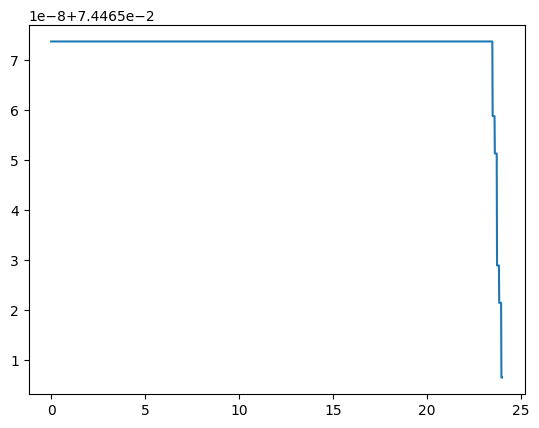

In [33]:
flow_time_plot=np.arange(0,1,1/1440) 
flow_time=np.vstack((1*np.ones_like(flow_time_plot, dtype=int),(1*np.ones_like(flow_time_plot, dtype=int)),flow_time_plot)).T
flow_result = model_calosc_danych_bez_dodatku.predict(flow_time)

plt.plot(xplot, flow_result)
plt.xlabel('Czas dnia, h')
plt.ylabel('Przepływ, l/min')

# model 4 input

In [ ]:
dataset = DATASET_CALOSC
x=dataset.drop(columns="Przeplyw")
y=dataset.drop(columns="Dzien_tygodnia")
y=y.drop(columns="Czas_dnia")
y=y.drop(columns="Tyg_zuzycie")
y=y.drop(columns="Pora_roku")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model_calosc_danych_z_dodatku =build_and_compile_model_input(4)
model_calosc_danych_z_dodatku.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)
model_calosc_danych_z_dodatku.save("../Modele/11_12_testowanie/model_calosc_z_dodatku")

Epoch 1/50
26208/26208 [==============================] - 48s 2ms/step - loss: 0.5507 - mae: 0.1657 - lr: 0.0010
Epoch 2/50
26208/26208 [==============================] - 48s 2ms/step - loss: 0.5475 - mae: 0.1653 - lr: 0.0010
Epoch 3/50
26208/26208 [==============================] - 48s 2ms/step - loss: 0.5473 - mae: 0.1658 - lr: 0.0010
Epoch 4/50
26208/26208 [==============================] - 47s 2ms/step - loss: 0.5462 - mae: 0.1653 - lr: 0.0010
Epoch 5/50
26208/26208 [==============================] - 48s 2ms/step - loss: 0.5458 - mae: 0.1654 - lr: 9.0484e-04
Epoch 6/50
26208/26208 [==============================] - 49s 2ms/step - loss: 0.5454 - mae: 0.1654 - lr: 8.1873e-04
Epoch 7/50
26208/26208 [==============================] - 48s 2ms/step - loss: 0.5448 - mae: 0.1651 - lr: 7.4082e-04
Epoch 8/50
26208/26208 [==============================] - 48s 2ms/step - loss: 0.5448 - mae: 0.1656 - lr: 6.7032e-04
Epoch 9/50
26208/26208 [==============================] - 47s 2ms/step - loss: 0

45/45 [==============================] - 0s 1ms/step


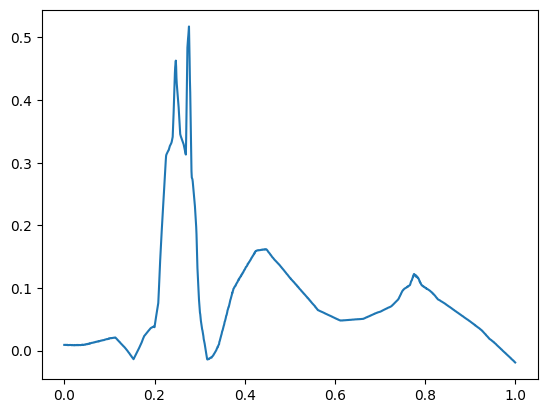

In [ ]:
flow_time_plot=np.arange(0,1,1/1440) 

result = dataset.loc[(dataset['Dzien_tygodnia'] == 1) & (dataset['Pora_roku'] == 1),"Tyg_zuzycie"]
flow_time=np.vstack((1*np.ones_like(flow_time_plot, dtype=int),(1*np.ones_like(flow_time_plot, dtype=int)),flow_time_plot,result.mean()*np.ones_like(flow_time_plot, dtype=int))).T
flow_result = model_calosc_danych_z_dodatku.predict(flow_time)

plt.plot(xplot, flow_result)
plt.xlabel('Czas dnia, h')
plt.ylabel('Przepływ, l/min')

# Porównanie

In [34]:
def prep_data(data):
    data=data.drop(columns="Tyg_zuzycie")
    data['Czas_dnia'] = data['Czas_dnia'] 
    x=data.drop(columns="Przeplyw")
    y=data.drop(columns="Dzien_tygodnia")
    y=y.drop(columns="Czas_dnia")
    y=y.drop(columns="Pora_roku")
    return [x,y]

Epoch 1/50
1665/2016 [=======================>......] - ETA: 0s - loss: 0.6832 - mae: 0.1593

KeyboardInterrupt: 

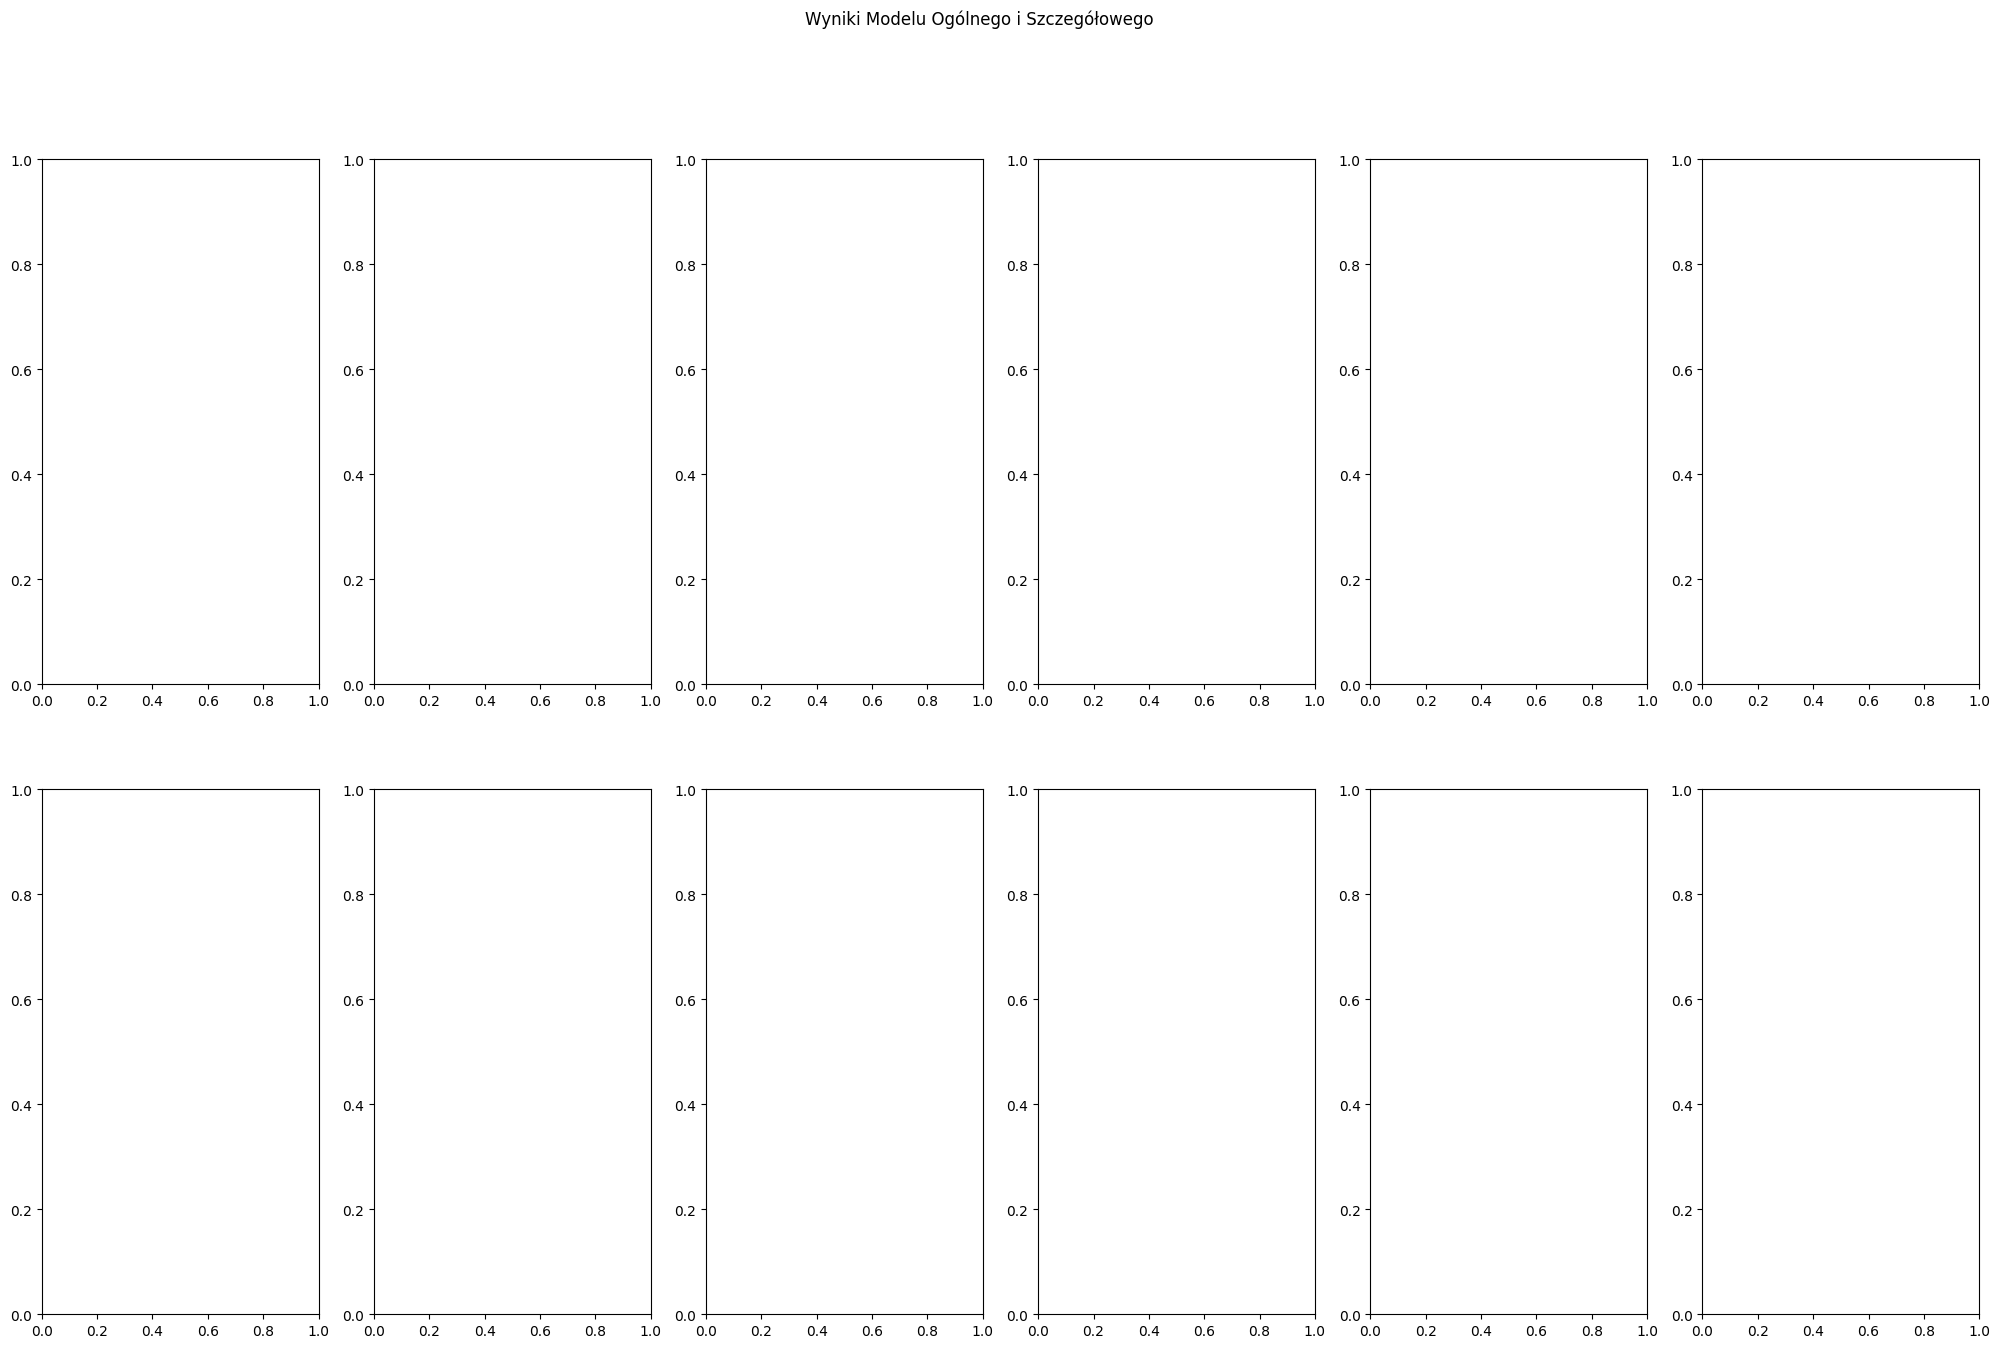

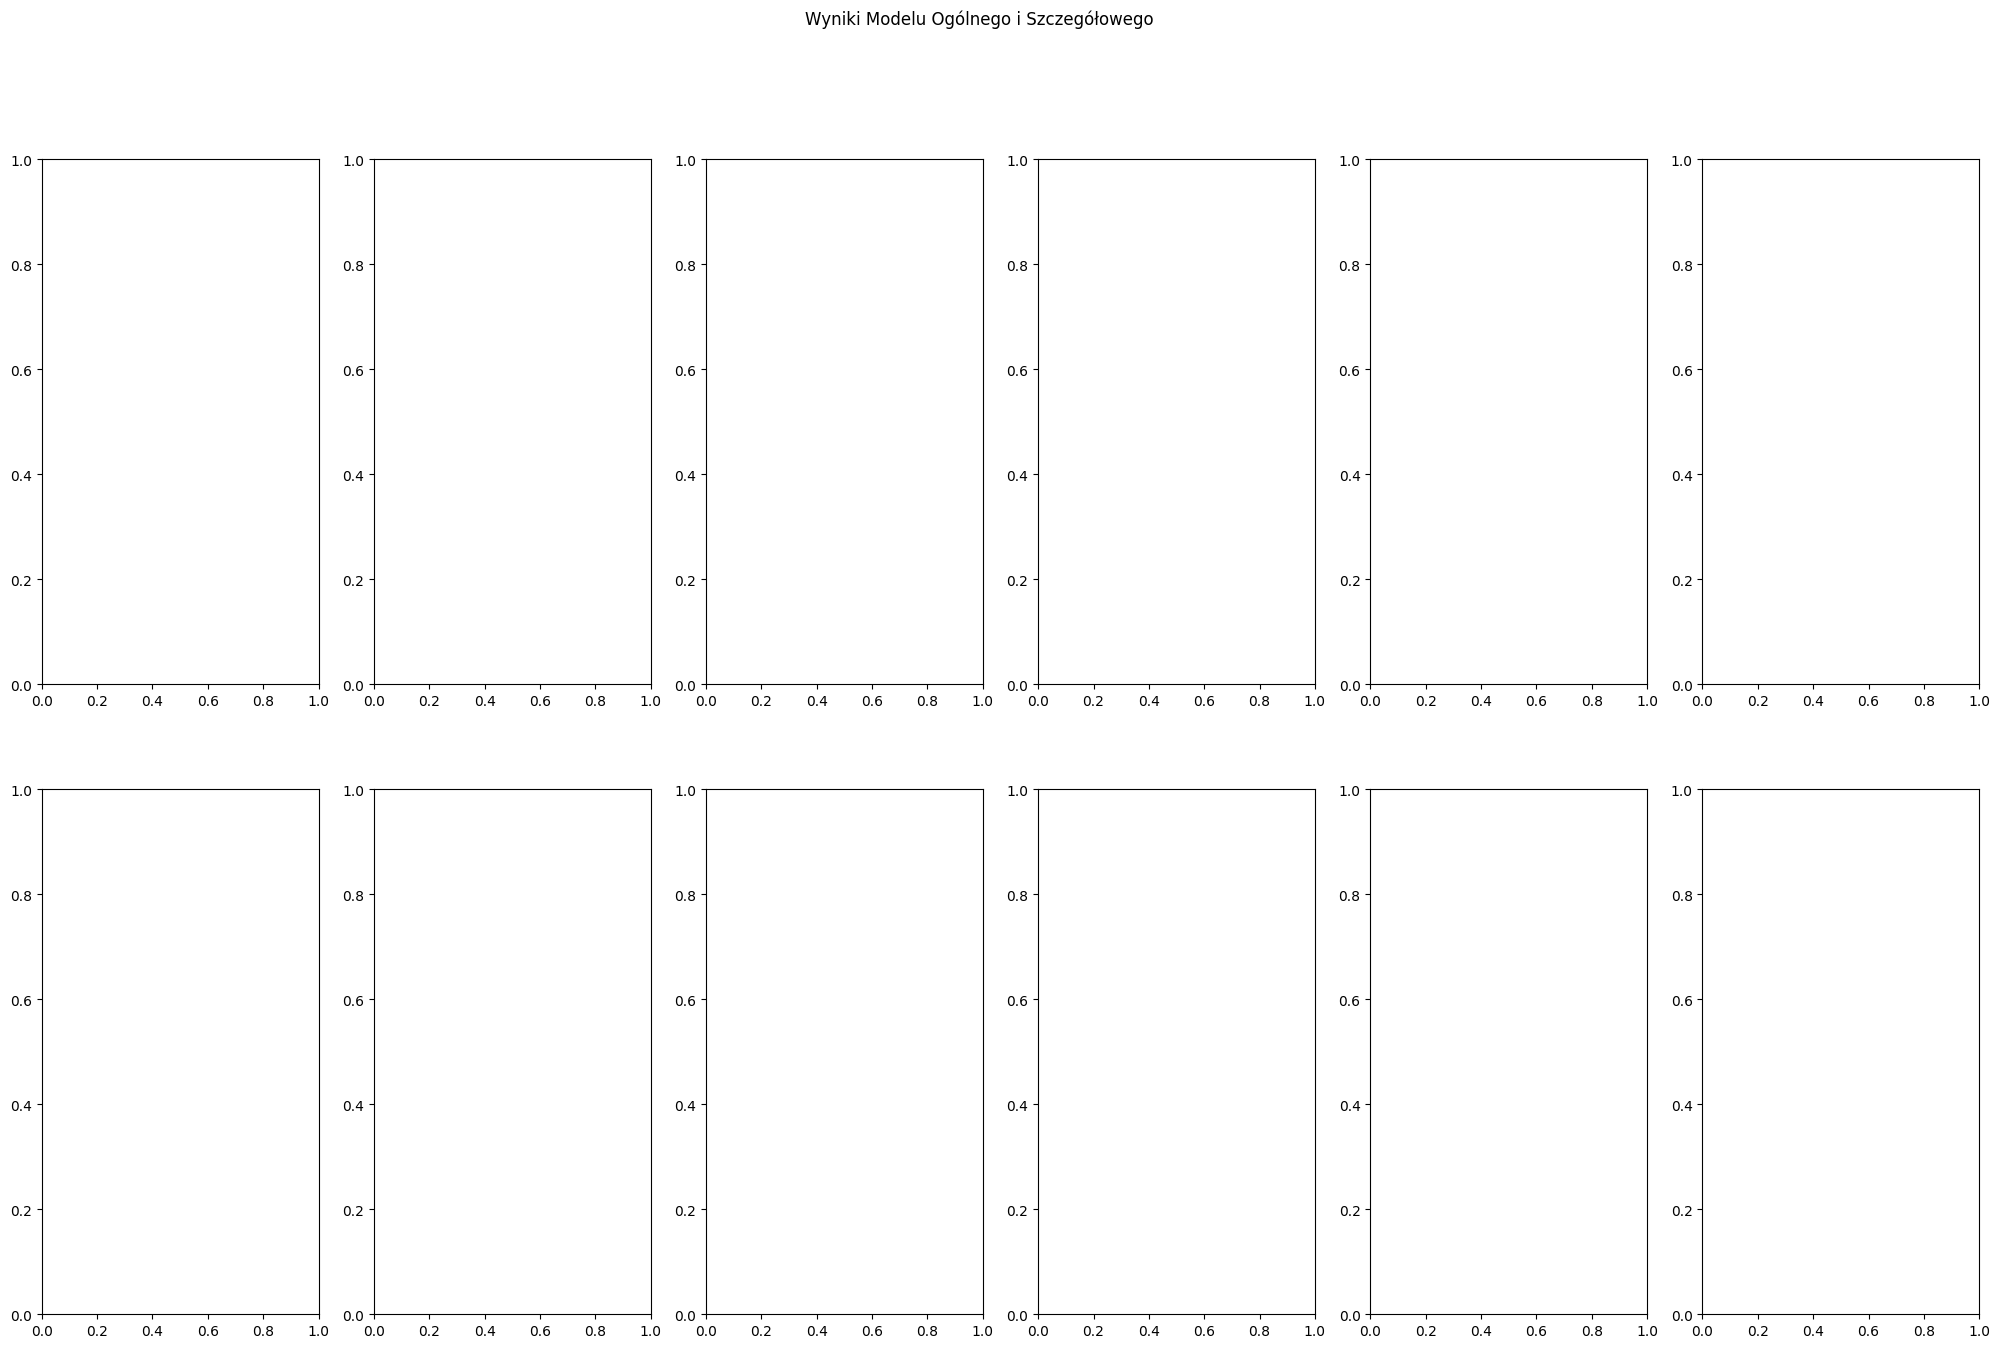

In [40]:
mse_matrix=np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0]
])
fig_1, axs_1 = plt.subplots(2, 6,figsize=(25, 15))
fig_1.suptitle('Wyniki Modelu Ogólnego i Szczegółowego')

fig_3, axs_3 = plt.subplots(2, 6,figsize=(25, 15))
fig_3.suptitle('Wyniki Modelu Ogólnego i Szczegółowego')

path = os.getcwd() 
csv_files = glob.glob(os.path.join(path, '../Dane/data_nowe/dane_przetworzone/12_wybranych_nowy_parametr/*.csv')) 
i=0;
k=0;
model_number=0
for f in csv_files: 
    dataset = pd.read_csv(f) 
    dataset['Tyg_zuzycie'] = (dataset['Tyg_zuzycie']) / (DATASET_CALOSC_MAX)
    [x,y]=prep_data(dataset) 

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model_temp =build_and_compile_model_input(3)
    model_temp.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)
    model_temp.save("../Modele/11_12_testowanie/szczegółowe/model_calosc_z_dodatku_"+str(model_number))
    
    input_3=np.vstack((2*np.ones_like(flow_time_plot, dtype=int),(2*np.ones_like(flow_time_plot, dtype=int), flow_time_plot))).T

    output_1=model_temp.predict(input_3)
    axs_1[k,i].plot(xplot, output_1.reshape(1440),label='Model szczególny')
    output_2=model_calosc_danych_bez_dodatku.predict(input_3)
    axs_1[k,i].plot(xplot, output_2.reshape(1440),label='Model ogólny')
    axs_1[k,i].set_xlim(0, 1)
    axs_1[k,i].set_xlabel('Czas dnia')
    axs_1[k,i].set_ylabel('Przepływ')
    mse=mean_squared_error(output_1,output_2)
    axs_1[k,i].set_title("Dom: "+ str(model_number+1))
    axs_1[k,i].legend()

    mse_matrix[0, model_number]=mse

    result = dataset.loc[(dataset['Dzien_tygodnia'] == 2) & (dataset['Pora_roku'] == 2),"Tyg_zuzycie"]
    input_4=np.vstack((2*np.ones_like(flow_time_plot, dtype=int), 2*np.ones_like(flow_time_plot, dtype=int), flow_time_plot, result.mean()*np.ones_like(flow_time_plot, dtype=int))).T
    axs_3[k,i].plot(xplot, output_1.reshape(1440),label='Model szczególny')
    output_4=model_calosc_danych_z_dodatku.predict(input_4)
    axs_3[k,i].plot(xplot, output_4.reshape(1440),label='Model ogolny')
    axs_3[k,i].set_xlim(0, 1)
    axs_3[k,i].set_xlabel('Czas dnia')
    axs_3[k,i].set_ylabel('Przepływ')
    mse=mean_squared_error(output_1,output_4)
    axs_3[k,i].set_title("Dom: "+str(model_number+1))
    axs_3[k,i].legend()

    mse_matrix[1, model_number]=mse

    i+=1
    model_number+=1
    if i==6:
        k=1
        i=0

plt.tight_layout()

plt.show()


In [ ]:
macierz = np.array([
    [1,2],
    [3,4],
    [5,6]
])

# Dodawanie elementu do pierwszego rzędu i pierwszej kolumny
nowa_wartosc = 10
macierz[1, 0] = nowa_wartosc

print(macierz)

[[ 1  2]
 [10  4]
 [ 5  6]]
